# Import of libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Loading the data

In [32]:
# Retrieve the historical data of S&P500 index - last 30 years
sp500 = yf.download("^GSPC", start="1994-04-30", end="2024-04-30")

# Print out last five days
sp500.tail(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-16,5064.589844,5079.839844,5039.830078,5051.410156,5051.410156,4006200000
2024-04-17,5068.970215,5077.959961,5007.250000,5022.209961,5022.209961,3596130000
2024-04-18,5031.520020,5056.660156,5001.890137,5011.120117,5011.120117,3619760000
2024-04-19,5005.439941,5019.020020,4953.560059,4967.229980,4967.229980,3878750000
2024-04-22,4987.330078,5038.839844,4969.399902,5010.600098,5010.600098,3820250000
2024-04-23,5028.850098,5076.120117,5027.959961,5070.549805,5070.549805,3751400000
2024-04-24,5084.859863,5089.479980,5047.020020,5071.629883,5071.629883,3656740000
2024-04-25,5019.879883,5057.750000,4990.580078,5048.419922,5048.419922,3958050000
2024-04-26,5084.649902,5114.620117,5073.140137,5099.959961,5099.959961,3604140000


# Data Cleaning 

In [33]:
# Drop irrelevant columns for the analysis
sp500 = sp500.drop(columns = ['Adj Close','Volume','High','Low'])

In [34]:
# Move the date outside the index
sp500.reset_index(inplace = True)

In [35]:
# Check if any date falls on a Saturday or Sunday
has_weekend_days = any(sp500['Date'].dt.dayofweek.isin([5, 6]))  # 5 represents Saturday and 6 represents Sunday

if has_weekend_days:
    print("There are weekend days in the 'Date' column.")
else:
    print("There are no weekend days in the 'Date' column.")

There are no weekend days in the 'Date' column.


----------
    We can see that only trading days are present - no weekdays, no bank holidays. That is convenient for the analysis and we do not need to clean the data based on this criteria
----------

In [36]:
# Inspect the dataset for missing values
sp500.isna().value_counts()

Date   Open   Close
False  False  False    7552
Name: count, dtype: int64

---
    We can see that the data does not contain any null values. It does not need any processing in this realm.
---

# Data Enrichment

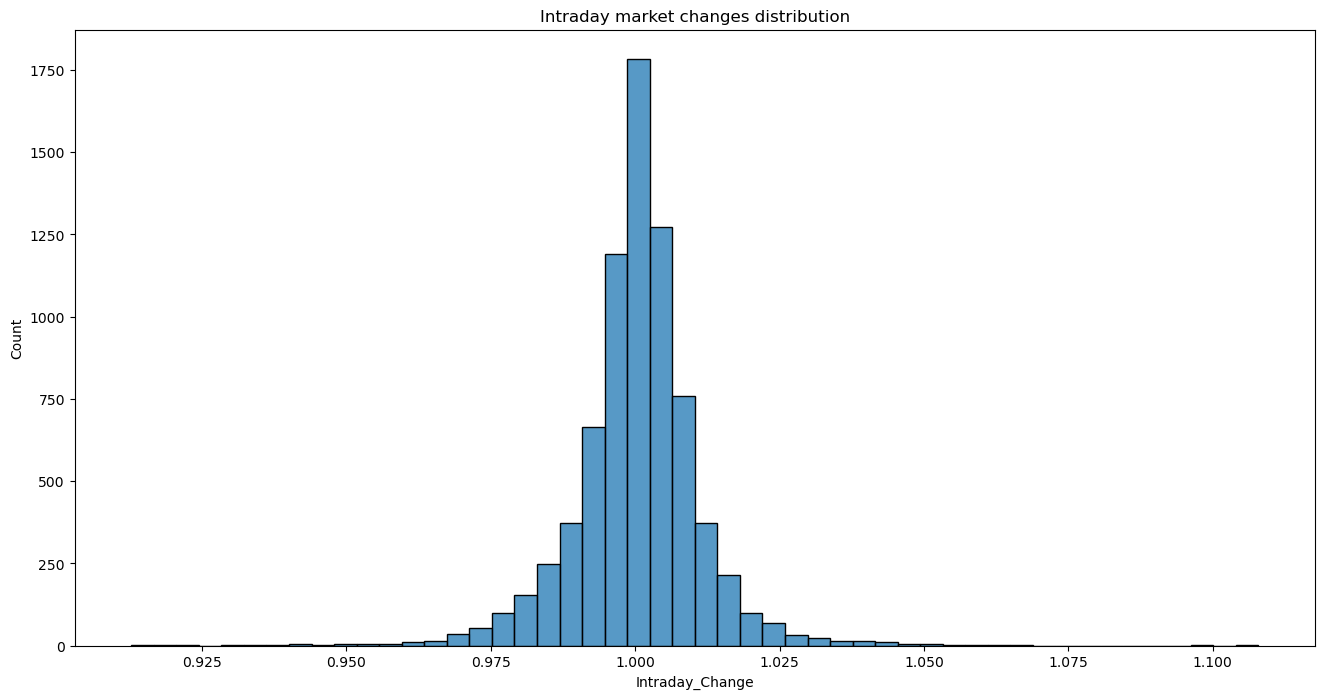

In [65]:
# Calculate the intraday index-value change
sp500['Intraday_Change'] = sp500['Close'] / sp500['Open']

# Plot the histogram of intraday returns
plt.figure(figsize=(16,8))
sns.histplot(data = sp500['Intraday_Change'], bins = 50)
plt.title('Intraday market changes distribution')
plt.show()

---
    We can see that the returns follow a nearly perfect normal distribution.
---

In [38]:
# Calculate the overall stock market return of all values in the 'intraday_change_pct' column
overall_return = sp500['Intraday_Change'].prod()

# Print the result
print(f'The overall stock market return in the last 30 years was {round(overall_return * 100, 2)}%.')

The overall stock market return in the last 30 years was 681.74%.


In [111]:
# Calculate the condition for at least 1% drop for two consecutive rows
two_days_consecutive_minus_one_pct = (sp500['Intraday_Change'] <= 0.99) & (sp500['Intraday_Change'].shift(-1) <= 0.99)

# Calculate the sum of this occurence
sum_two_days_consecutive_minus_one_pct = two_days_consecutive_minus_one_pct.sum()

# Print the results
print("Occurrences of at least two days with at least 1% drop in the given timeframe is:", sum_two_days_consecutive_minus_one_pct)

Occurrences of at least two days with at least 1% drop in the given timeframe is: 161


In [112]:
# How often does this happen 
print(f'Every {(len(sp500) / sum_two_days_consecutive_minus_one_pct).round(2)} days')

Every 46.91 days


---
    47 days seems like a favourable interval value for market entries in a regular investment strategy.
---

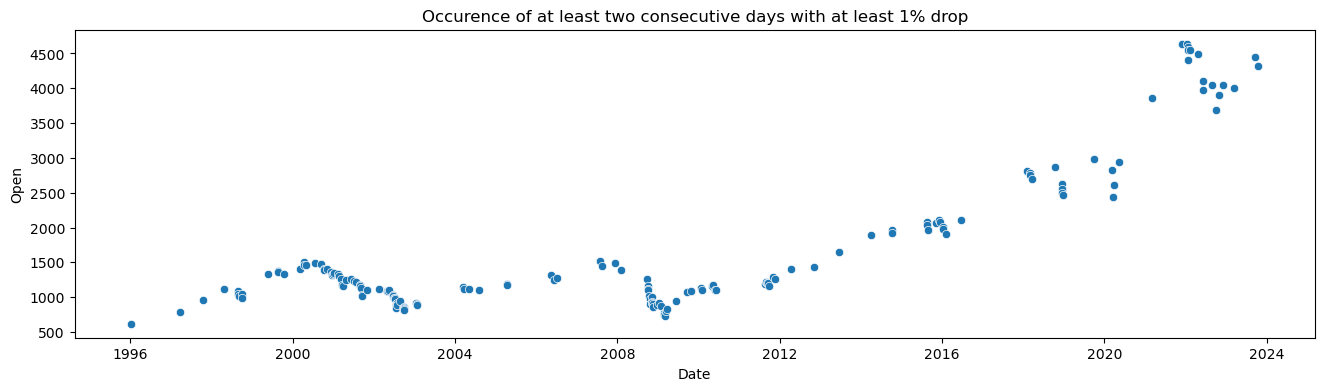

In [113]:
# Plot the histogram of intraday returns
plt.figure(figsize=(16,4))
sns.scatterplot(data = sp500[two_days_consecutive_minus_one_pct], x = 'Date', y = 'Open')
plt.title('Occurence of at least two consecutive days with at least 1% drop')
plt.show()

---
    We can see that the occurence of two consecutive days with at least 1% drop are not evenly distributed. They are quite logically concetrated in years that were generally volatile due to overall global economy recessions. This in not optimal, since there would be years such as 2017/2018, where virtually no market entries would be made. On the other hand, we would need a lot of free cashflow in 2009 to be able to enter the market so many times. From this perspective, the market timing based on the proposed strategy does not look very reasonable. Anyways, let us investigate further.|
---

# Simulation of scenarios

---
    We will firstly create two new columns that will hold the deposits made by a theoretical investor. We will have two scenarios:

    In the first scenario S1, the investor will invest on a DCA principal - investing periodically every 47 days.
    In the second scenario S2, the investor will invest using a proposed strategy.
---

In [114]:
# Create a new column for scenario S1 deposits that we will populate with data in the following step
sp500['Investment_Deposit_S1'] = 0

In [115]:
# Create an array of days, on which a deposit will be made for scenario s1
# In order to get a valid day number for the last date, I am subtracting 1 from the stop argument
days_of_deposit_s1 = np.linspace(start = 0, stop = (len(sp500.index) - 1), num = sum_two_days_consecutive_minus_one_pct, dtype = 'int')
days_of_deposit_s1

array([   0,   47,   94,  141,  188,  235,  283,  330,  377,  424,  471,
        519,  566,  613,  660,  707,  755,  802,  849,  896,  943,  991,
       1038, 1085, 1132, 1179, 1227, 1274, 1321, 1368, 1415, 1463, 1510,
       1557, 1604, 1651, 1698, 1746, 1793, 1840, 1887, 1934, 1982, 2029,
       2076, 2123, 2170, 2218, 2265, 2312, 2359, 2406, 2454, 2501, 2548,
       2595, 2642, 2690, 2737, 2784, 2831, 2878, 2926, 2973, 3020, 3067,
       3114, 3161, 3209, 3256, 3303, 3350, 3397, 3445, 3492, 3539, 3586,
       3633, 3681, 3728, 3775, 3822, 3869, 3917, 3964, 4011, 4058, 4105,
       4153, 4200, 4247, 4294, 4341, 4389, 4436, 4483, 4530, 4577, 4624,
       4672, 4719, 4766, 4813, 4860, 4908, 4955, 5002, 5049, 5096, 5144,
       5191, 5238, 5285, 5332, 5380, 5427, 5474, 5521, 5568, 5616, 5663,
       5710, 5757, 5804, 5852, 5899, 5946, 5993, 6040, 6087, 6135, 6182,
       6229, 6276, 6323, 6371, 6418, 6465, 6512, 6559, 6607, 6654, 6701,
       6748, 6795, 6843, 6890, 6937, 6984, 7031, 70

In [116]:
# For every day in the days_of_deposit_s1, insert a deposit of 1000 units
def insert_deposit_days_s1(sp500: DataFrame) -> DataFrame :
    for day_number in days_of_deposit_s1:
        sp500.loc[day_number, 'Investment_Deposit_S1'] = 1000
    
    return sp500

# Apply the function
insert_deposit_days_s1(sp500)

,Date,Open,Close,Intraday_Change,Investment_Deposit_S1,Investment_Deposit_S2,Total_Portfolio_Value_S1,Total_Portfolio_Value_S2
0,1994-05-02,450.910004,453.019989,1.004679,1000,0,1004.679394,0.000000
1,1994-05-03,453.059998,453.029999,0.999934,0,0,1004.612870,0.000000
2,1994-05-04,453.040009,451.720001,0.997086,0,0,1001.685764,0.000000
3,1994-05-05,451.720001,451.380005,0.999247,0,0,1000.931824,0.000000
4,1994-05-06,451.369995,447.820007,0.992135,0,0,993.059578,0.000000
...,...,...,...,...,...,...,...,...
7547,2024-04-23,5028.850098,5070.549805,1.008292,0,0,270577.472041,265763.552875
7548,2024-04-24,5084.859863,5071.629883,0.997398,0,0,269873.473354,265072.079224
7549,2024-04-25,5019.879883,5048.419922,1.005685,0,0,271407.812751,266579.120761
7550,2024-04-26,5084.649902,5099.959961,1.003011,0,0,272225.031162,267381.799813


In [117]:
# Create a deposit column for scenario S2. We will populate the column in the following cell
sp500['Investment_Deposit_S2'] = 0

In [118]:
# Insert deposits for scenario S2 based on an entry signal condition specified earlier
def insert_deposit_days_s2(sp500: DataFrame) -> DataFrame:
    # Filter the DataFrame based on the given criteria
    filtered_dates = sp500['Date'][two_days_consecutive_minus_one_pct].index

    # Insert deposit values into the original DataFrame
    for date in filtered_dates:
        sp500.loc[date, 'Investment_Deposit_S2'] = 1000

    return sp500

insert_deposit_days_s2(sp500)

,Date,Open,Close,Intraday_Change,Investment_Deposit_S1,Investment_Deposit_S2,Total_Portfolio_Value_S1,Total_Portfolio_Value_S2
0,1994-05-02,450.910004,453.019989,1.004679,1000,0,1004.679394,0.000000
1,1994-05-03,453.059998,453.029999,0.999934,0,0,1004.612870,0.000000
2,1994-05-04,453.040009,451.720001,0.997086,0,0,1001.685764,0.000000
3,1994-05-05,451.720001,451.380005,0.999247,0,0,1000.931824,0.000000
4,1994-05-06,451.369995,447.820007,0.992135,0,0,993.059578,0.000000
...,...,...,...,...,...,...,...,...
7547,2024-04-23,5028.850098,5070.549805,1.008292,0,0,270577.472041,265763.552875
7548,2024-04-24,5084.859863,5071.629883,0.997398,0,0,269873.473354,265072.079224
7549,2024-04-25,5019.879883,5048.419922,1.005685,0,0,271407.812751,266579.120761
7550,2024-04-26,5084.649902,5099.959961,1.003011,0,0,272225.031162,267381.799813


In [119]:
# Make sure that there is an identical number of deposits in both scenarios
print(sp500['Investment_Deposit_S2'].value_counts())
print(sp500['Investment_Deposit_S1'].value_counts())

Investment_Deposit_S2
0       7391
1000     161
Name: count, dtype: int64
Investment_Deposit_S1
0       7391
1000     161
Name: count, dtype: int64


In [120]:
# Create a S1 column that will be populated in the next step
sp500['Total_Portfolio_Value_S1'] = 0 

In [121]:
# Initialize the value of Total_Portfolio_Value_S1 for the first row
sp500.at[0, 'Total_Portfolio_Value_S1'] = sp500.at[0, 'Intraday_Change'] * sp500.at[0, 'Investment_Deposit_S1']

# Iterate over each row starting from the second row and perform calculations
for day in range(1, len(sp500)):
    sp500.at[day, 'Total_Portfolio_Value_S1'] = sp500.at[day, 'Intraday_Change'] * (sp500.at[day - 1, 'Total_Portfolio_Value_S1'] + sp500.at[day, 'Investment_Deposit_S1'])

print(f'With a simple DCA strategy, the total portfolio value on the last day of the dataframe would be {sp500.iloc[-1,-2].round()} money units')

With a simple DCA strategy, the total portfolio value on the last day of the dataframe would be 382388.0 money units


In [122]:
# Initialize the value of Total_Portfolio_Value_S2 for the first row
sp500.at[0, 'Total_Portfolio_Value_S2'] = sp500.at[0, 'Intraday_Change'] * sp500.at[0, 'Investment_Deposit_S2']

# Iterate over each row starting from the second row and perform calculation of overall returns
for day in range(1, len(sp500)):
    sp500.at[day, 'Total_Portfolio_Value_S2'] = sp500.at[day, 'Intraday_Change'] * (sp500.at[day - 1, 'Total_Portfolio_Value_S2'] + sp500.at[day, 'Investment_Deposit_S2'])

print(f'With the proposed investment strategy, the total portfolio value on the last day of the dataframe would be {sp500.iloc[-1,-1].round()} money units')

With the proposed investment strategy, the total portfolio value on the last day of the dataframe would be 377996.0 money units


# Conclusion

---
    The analysis showed that the proposed strategy did not yield a better overall portfolio return than the DCA (Dollar-Cost-Averaging) strategy. It adds to many other studies and voices that advice that an investor (especially a non-proffesional one) should not attempt to time the stock market. 
    
    Note: I also tested other strategies, such as three consecutive days with at least 0.5% drop, two consecutive days with  at least 0.8% and more. None of these was able to beat the DCA strategy.
---